In [ ]:
import os
import cv2
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D



In [ ]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  # crawls inside folders
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count
train_dir ="/content/drive/MyDrive/Colab Notebooks/tea_disease/tea sickness dataset/train_ds"
test_dir="/content/drive/MyDrive/Colab Notebooks/tea_disease/tea sickness dataset/val_ds"

In [ ]:
 #train file image count
train_samples =get_files(train_dir)
#to get tags
num_classes=len(glob.glob(train_dir+"/*"))
#test file image count
test_samples=get_files(test_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

8 Classes
749 Train images
232 Test images


In [ ]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
     fill_mode='nearest',
    horizontal_flip=True,
     vertical_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [ ]:
input_shape=(256,256,3)
train_generator =train_datagen.flow_from_directory(train_dir,target_size=(256,256),batch_size=32)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(256,256),batch_size=32)

Found 749 images belonging to 8 classes.
Found 232 images belonging to 8 classes.


In [ ]:
def create_Base_model_from_VGG19():
    model_vgg19 = VGG19(
        weights = "imagenet",# control point from which model is started
        include_top=False, # to include/exclude the first 3 layers
        input_shape = (256,256, 3)) # image size
    # don't train existing weights
    for layer in model_vgg19.layers:
      layer.trainable = False
    return model_vgg19
create_Base_model_from_VGG19().summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
def add_custom_layers_vgg19():
    #Adding custom Layers
    model_vgg19 = create_Base_model_from_VGG19()
    x = model_vgg19.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    # creating the final model
    final_model = tf.keras.models.Model(
        inputs = model_vgg19.input,
        outputs = predictions)

    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return final_model

add_custom_layers_vgg19().summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
model = add_custom_layers_vgg19()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir,
                       target_size=(256, 256),
                       batch_size=32)

Found 232 images belonging to 8 classes.


In [ ]:
history = model.fit(train_generator,
                      steps_per_epoch=None,
                      epochs=20,
                      validation_data=validation_generator,
                      validation_steps=None,
                      verbose=1,
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.001)],
                      use_multiprocessing=False,
                      shuffle=True)

Epoch 1/20
24/24 [==============================] - 629s 26s/step - loss: 5.0759 - accuracy: 0.2083 - val_loss: 1.7628 - val_accuracy: 0.2931 - lr: 0.0010
Epoch 2/20
24/24 [==============================] - 628s 26s/step - loss: 1.3731 - accuracy: 0.4780 - val_loss: 1.1075 - val_accuracy: 0.6078 - lr: 0.0010
Epoch 3/20
24/24 [==============================] - 631s 26s/step - loss: 1.0997 - accuracy: 0.5821 - val_loss: 1.0540 - val_accuracy: 0.5905 - lr: 0.0010
Epoch 4/20
24/24 [==============================] - 683s 29s/step - loss: 0.9320 - accuracy: 0.6609 - val_loss: 0.8329 - val_accuracy: 0.7284 - lr: 0.0010
Epoch 5/20
24/24 [==============================] - 627s 26s/step - loss: 0.7704 - accuracy: 0.7143 - val_loss: 0.9205 - val_accuracy: 0.6595 - lr: 0.0010
Epoch 6/20
24/24 [==============================] - 628s 27s/step - loss: 0.7440 - accuracy: 0.7276 - val_loss: 0.8391 - val_accuracy: 0.7112 - lr: 0.0010
Epoch 7/20
24/24 [==============================] - 628s 26s/step - lo

In [ ]:
result = model.evaluate(train_generator)
dict(zip(model.metrics_names, result))

24/24 [==============================] - 478s 20s/step - loss: 0.2357 - accuracy: 0.9239


{'loss': 0.23574906587600708, 'accuracy': 0.9238985180854797}

In [ ]:
result = model.evaluate(validation_generator)
dict(zip(model.metrics_names, result))

8/8 [==============================] - 147s 18s/step - loss: 0.3774 - accuracy: 0.8793


{'loss': 0.3773688077926636, 'accuracy': 0.8793103694915771}

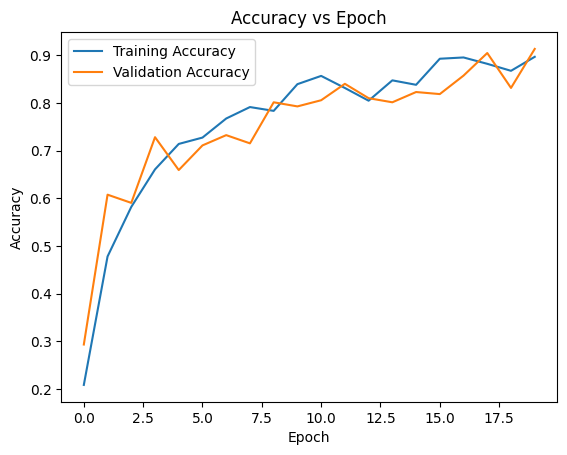

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

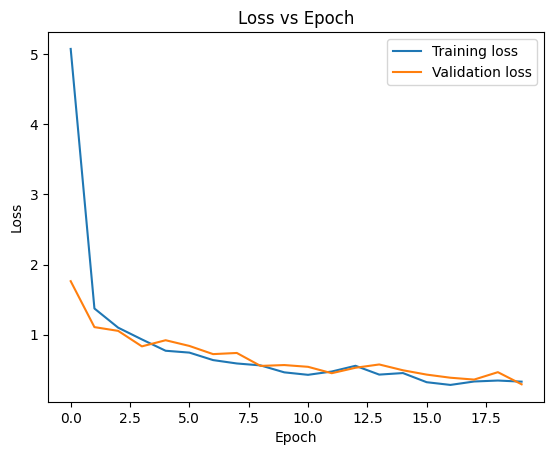

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

8/8 [==============================] - 147s 18s/step


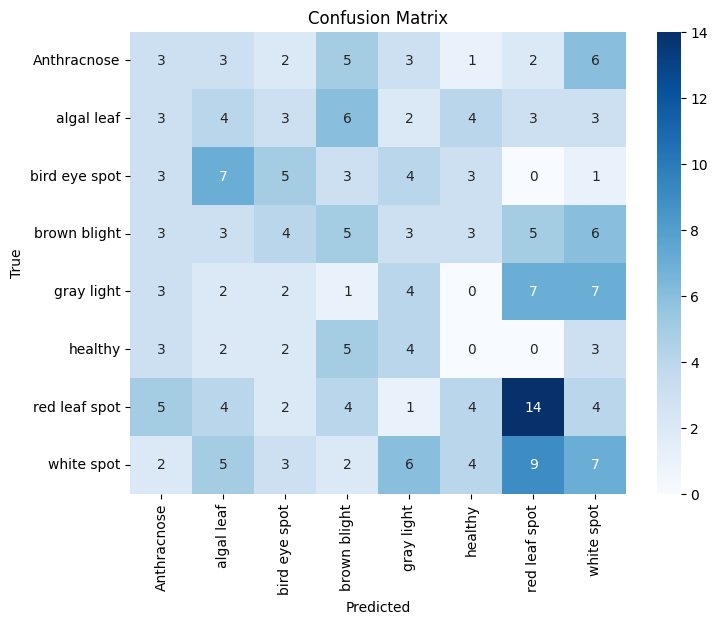

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `model` is your trained model
# Assuming `validation_generator` contains validation data and labels

# Make predictions on the validation set
predictions = model.predict(validation_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Obtain true labels from the validation generator
true_labels = validation_generator.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
class_names = validation_generator.class_indices.keys()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Assuming test_dir is the path to your validation data directory
validation_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',  # Adjust this based on your problem (binary or multiclass)
    shuffle=False  # Keep the order for evaluation
)

# Assuming model is your trained model
# Assuming history and plt are already defined in your code

# Make predictions on the validation set
predictions = model.predict(validation_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Obtain true labels from the validation generator
true_labels = validation_generator.classes

# Calculate precision, recall, and F1-score
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Found 232 images belonging to 8 classes.
8/8 [==============================] - 148s 18s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        25
           1       0.83      0.71      0.77        28
           2       0.95      0.73      0.83        26
           3       0.83      0.94      0.88        32
           4       0.92      0.92      0.92        26
           5       1.00      1.00      1.00        19
           6       0.97      0.97      0.97        38
           7       0.88      0.92      0.90        38

    accuracy                           0.89       232
   macro avg       0.90      0.89      0.89       232
weighted avg       0.90      0.89      0.89       232

